# Error Bar Illustration

In [41]:
from datetime import datetime
from matplotlib import pylab as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import skewnorm

sns.set()

In [26]:
time_range = (pd.Timestamp("2010-05-13 0:00:00"), pd.Timestamp("2010-06-01 00:00:00"))

In [33]:
# Read from Disk
df_dataset = pd.read_csv("../data/processed/test/processed_daysahead3_R000.csv")
df_dataset.forward_time = pd.to_datetime(df_dataset.forward_time)

# Subset
df_dataset = df_dataset[df_dataset.forward_time.between(*time_range)]

# Print
df_dataset.head()

,current_time,forward_time,forward_Vp_pred,forward_Vp_obs,forward_mean,forward_sigma,forward_skew,forward_crps
502,2010-05-10 06:00:00,2010-05-13 00:00:00,475.233333,448.28,-140.662202,134.815796,2.136005,67.650357
503,2010-05-10 12:00:00,2010-05-13 06:00:00,454.033333,414.89,-158.121934,156.332358,3.442778,71.010696
504,2010-05-10 18:00:00,2010-05-13 12:00:00,438.600000,380.22,-138.693422,140.189688,2.758409,50.631269
505,2010-05-11 00:00:00,2010-05-13 18:00:00,422.000000,380.81,-156.453594,148.023092,5.429725,68.693746
506,2010-05-11 06:00:00,2010-05-14 00:00:00,406.100000,358.60,-110.819956,123.661082,2.384283,41.558356


In [11]:
df_obs = pd.read_csv("../data/ace_hr.dat", sep="\\s+", comment="#")
df_obs = df_obs[df_obs.year >= df_dataset.index.min().year]
df_obs = df_obs[df_obs.year <= df_dataset.index.max().year]
df_obs.index = [
    datetime(int(row.year), int(row.month), int(row.day), int(row.hour))
    for _, row in df_obs.iterrows()
]

In [5]:
df_obs.head()

,juldate,month,day,hour,year,doy,Vp_obs,Br_obs,imf_obs,Np_obs,beta_obs
2010-01-01 00:00:00,15197.50,1,1,0,2010,1,276.62,0.09,1.0,0.0,0.0
2010-01-01 01:00:00,15197.54,1,1,1,2010,1,271.82,0.63,1.0,0.0,0.0
2010-01-01 02:00:00,15197.58,1,1,2,2010,1,273.09,0.58,1.0,0.0,0.0
2010-01-01 03:00:00,15197.62,1,1,3,2010,1,278.73,-0.05,-1.0,0.0,0.0
2010-01-01 04:00:00,15197.67,1,1,4,2010,1,271.79,0.11,1.0,0.0,0.0


In [50]:
err1 = []
err2 = []

for _, row in df_dataset.iterrows():
    dist = skewnorm(
        row.forward_skew,
        loc=row.forward_Vp_pred + row.forward_mean,
        scale=row.forward_sigma,
    )
    err1.append(dist.interval(0.75))
    err2.append(dist.interval(0.99))

err1 = np.array(err1)
err2 = np.array(p75)
err1.shape

(77, 2)

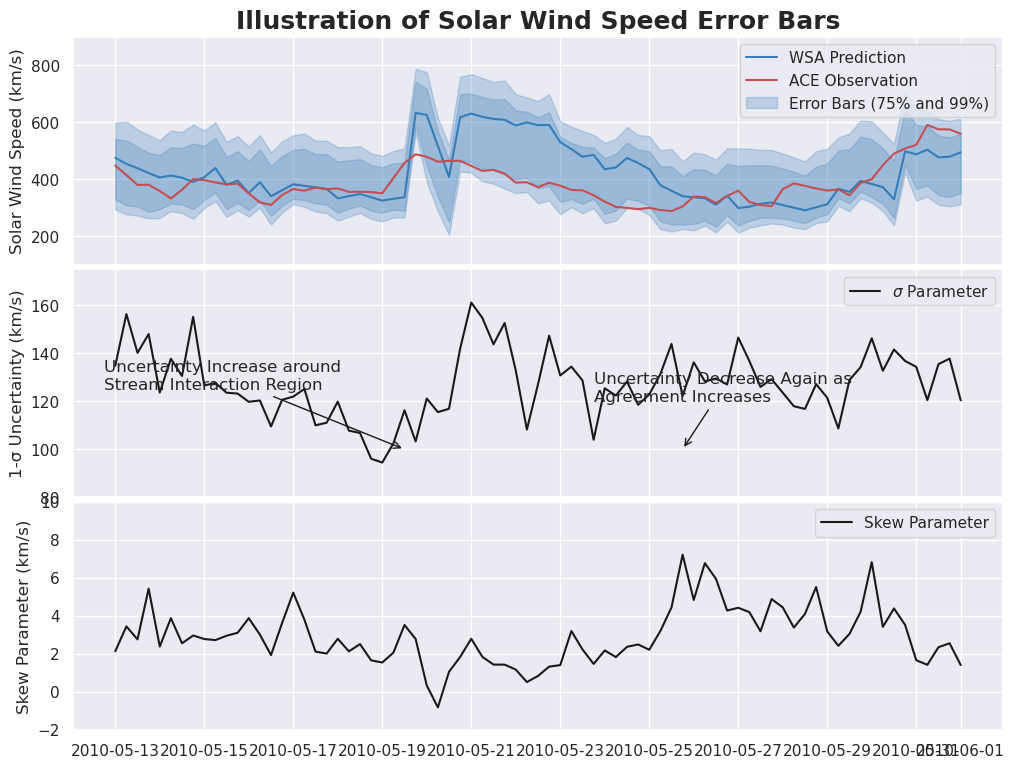

In [52]:
blue_color = "#367cb9"
red_color = "r"
black_color = "k"
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(12, 9))

# Error Bars ------------------------------
ax = axes[0]
ax.plot(
    df_dataset["forward_time"],
    df_dataset["forward_Vp_pred"],
    color=blue_color,
    label="WSA Prediction",
)
ax.plot(
    df_dataset["forward_time"],
    df_dataset["forward_Vp_obs"],
    color=red_color,
    label="ACE Observation",
)
ax.fill_between(
    df_dataset["forward_time"],
    p50[:, 0],
    p50[:, 1],
    alpha=0.25,
    color=blue_color,
    label="Error Bars (75% and 99%)",
)
ax.fill_between(
    df_dataset["forward_time"], p75[:, 0], p75[:, 1], alpha=0.25, color=blue_color
)
ax.set_ylabel("Solar Wind Speed (km/s)")
ax.set_yticks([200, 400, 600, 800])
ax.set_ylim(100, 900)

# Sigma Parameter ------------------------------
ax = axes[1]
ax.plot(
    df_dataset["forward_time"],
    df_dataset["forward_sigma"],
    color=black_color,
    label=r"$\sigma$ Parameter",
)
ax.set_ylabel("1-σ Uncertainty (km/s)")
ax.set_ylim(80, 175)
# ax.set_yticks([75, 100, 125])

ax.annotate(
    "Uncertainty Decrease Again as\nAgreement Increases",
    xytext=(pd.Timestamp("2010-05-23 18:00:00"), 120),
    xy=(pd.Timestamp("2010-05-25 18:00:00"), 100),
    arrowprops=dict(arrowstyle="->", color="k"),
)

ax.annotate(
    "Uncertainty Increase around\nStream Interaction Region",
    xytext=(pd.Timestamp("2010-05-12 18:00:00"), 125),
    xy=(pd.Timestamp("2010-05-19 12:00:00"), 100),
    arrowprops=dict(arrowstyle="->", color="k"),
)

# Skew Parameter ------------------------------
ax = axes[2]
ax.plot(
    df_dataset["forward_time"],
    df_dataset["forward_skew"],
    color=black_color,
    label="Skew Parameter",
)
ax.set_ylabel("Skew Parameter (km/s)")
ax.set_ylim(-2, 10)
# ax.set_yticks([75, 100, 125])


for ax in axes:
    ax.legend()

# i = 500
# print(repr((df_dataset.index[i], df_dataset.index[i + 100])))
#    ax.set_xlim(df_dataset.index[i], df_dataset.index[i + 100])

# plt.xlim(pd.Timestamp('2010-02-25 18:00:00'), pd.Timestamp('2010-03-22 18:00:00'))
axes[0].set_xlim()
axes[0].set_title(
    "Illustration of Solar Wind Speed Error Bars", fontweight="bold", fontsize=18
)
plt.subplots_adjust(wspace=0.4, hspace=0.02)
plt.savefig("../plots/error_bar_illustration.png", dpi=300)